In [1]:
import importlib.util
def module_from_file(module_name, file_path): #The code that imports the file which originated the training with all the instructions
            spec = importlib.util.spec_from_file_location(module_name, file_path)
            module = importlib.util.module_from_spec(spec)
            spec.loader.exec_module(module)
            return module

from importlib import import_module
#foo = import_module(fold_folder+'/Funs.py', package=None)


folder = './xforanalogs/NA24by48/Z8/yrs500/interT15fw20.1.20lrs4'
foo = module_from_file("foo", f'{folder}/Funs.py')

import random as rd  
from scipy.stats import norm
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn.metrics import log_loss

tff = foo.tff # tensorflow routines 
ut = foo.ut # utilities
ln = foo.ln #Learn2_new.py
print("==Checking GPU==")
import tensorflow as tf
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

print("==Checking CUDA==")
tf.test.is_built_with_cuda()

import sys
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
sys.path.insert(1, '../ERA')

print("==Reading data==")

year_permutation = np.load(f'{folder}/year_permutation.npy')

run_vae_kwargs = ut.json2dict(f"{folder}/config.json")
T = ut.extract_nested(run_vae_kwargs, 'T')
if (ut.keys_exists(run_vae_kwargs, 'label_period_start') and ut.keys_exists(run_vae_kwargs, 'label_period_end')):
    label_period_start = ut.extract_nested(run_vae_kwargs, 'label_period_start')
    label_period_end = ut.extract_nested(run_vae_kwargs, 'label_period_end')
    time_start = ut.extract_nested(run_vae_kwargs, 'time_start')
    time_end = ut.extract_nested(run_vae_kwargs, 'time_end')
    
    
n_days = time_end-time_start-T+1
n_days

import numpy as np
import pickle
import matplotlib.pyplot as plt

def Compare_Scores(runs, setnn=10, setcheck=10, savename='./Images/analog_taus.png'):
        """_summary_
                Computes and plots scores of training given the folders given in dictionary runs
        Args:
            runs (_type_): _description_
                Dictionary for the runs. The value contains the folder name, or if we want to shift the plots in days, it can be a list, of [folder,shift]
            setnn (int, optional): _description_. Defaults to 10.
                number of nearest neigbhors to plot 
            setcheck (int, optional): _description_. Defaults to 10.
            savename (str, optional): _description_. Defaults to './Images/analog_taus.png'.
                destination to save the figure
        """
        fig2 = plt.figure()
        fig2.set_size_inches(15, 4)
        ax = fig2.subplots(nrows=1, ncols=3)
        for name, folder in runs.items():
                print(name)
                if isinstance(folder, list):
                        shift = folder[1]
                        folder = folder[0]
                else:
                        shift = 0
                open_file = open(f'{folder}/committor.pkl', "rb")
                committor_dictionary = pickle.load(open_file)
                open_file.close()
                committor = committor_dictionary['committor']
                print(committor_dictionary.keys())
                print(committor_dictionary['RunFolds_kwargs_default'])
                delay = ut.extract_nested(committor_dictionary['RunFolds_kwargs_default'],'delay')
                chain_step = ut.extract_nested(committor_dictionary['RunFolds_kwargs_default'],'chain_step')
                import pandas as pd
                skill = committor_dictionary['skill']
                skill = []
                for check, value_check in committor_dictionary['skill'].items():
                        score_nn = []
                        for nn, value_nn in value_check.items():     
                                score_fold = []
                                for fold, value_fold in value_nn.items():
                                        score_fold.append(pd.DataFrame([value_fold], columns = -delay*chain_step) )
                                score_nn.append(pd.concat(score_fold, keys=value_nn.keys(),names=['fold', None]))
                        skill.append(pd.concat(score_nn, keys=value_check.keys(),names=['nn','fold', None]))
                skill = pd.concat(skill, keys =committor_dictionary['skill'].keys(), names=['check','nn','fold', None] )
                meanskill = skill.groupby(['check', 'nn']).mean() #.loc[(slice(None), 1), 'skill'] #.droplevel(level=(1,2)) 
                stdskill = skill.groupby(['check', 'nn']).std()
                tauarray = np.array([-tau for tau in meanskill])
                meanskilarray = np.array([meanskill[tau].max() for tau in meanskill])
                stdskillarray = np.array([stdskill[tau][meanskill[tau].idxmax()] for tau in stdskill])
                
                ax[0].plot(tauarray+shift, meanskilarray,label=name, marker='.')
                ax[0].fill_between(tauarray+shift,meanskilarray-stdskillarray,meanskilarray+stdskillarray,alpha=0.1)
        
                meanskill[0][(slice(None),setnn)].plot(ax = ax[1], label=f'nn = {setnn}', marker='.')
                if np.any(meanskill[0].index.isin([ setcheck], level='check')): # check if check exists
                    meanskill[0].loc[pd.IndexSlice[setcheck,:]].droplevel(level=(0)).plot(ax = ax[2], label=f'check = {setcheck}', marker='.')
                else:
                    print(f"Coudln't find {setcheck = } in  eanskill[0]")
                for j in list(meanskill.columns):
                        print(f"{meanskill[j].max():.2f}+-{stdskill[j][meanskill[j].idxmax()]:.2f}, {meanskill[j].idxmax()[0]}, {meanskill[j].idxmax()[1]}")
        ax[1].set_xscale('log')
        ax[2].set_xscale('log')
        #ax1.set_ylabel('skill')
        #ax.set_ylim([0,0.5])
        #ax.set_yscale("log")
        for i in range(3):
                ax[i].legend(loc='best', fancybox=True, framealpha=0.5)
                ax[i].grid(True)
                ax[i].set_ylabel('Normalized Log Score')
                ax[i].set_ylim([0,0.45])

        fig2.savefig('./Images/analog_taus.png',dpi=200,bbox_inches='tight')


2022-12-04 07:43:13.090997: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
In this environment you cannot import Basemap
In this environment you cannot import Basemap


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2022-12-04 07:43:19.409366: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


==Checking GPU==
==Checking CUDA==
==Reading data==


2022-12-04 07:43:19.478046: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-12-04 07:43:20.189822: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-12-04 07:43:20.189900: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (platinum1): /proc/driver/nvidia/version does not exist
2022-12-04 07:43:20.189927: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-04 07:43:20.192766: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set


Comparing raw analog method to the CNN 

NA/3scalars/
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield': 0, 'input_set': 'va', 'bulk_set': 'tr', 'RunCheckpoints_kwargs': {'allowselfanalogs': True, 'RunNeighbors_kwargs': {'num_Traj': 10000, 'T': 15, 'chain_step': 3, 'neighbors': [2, 3, 5, 10, 20, 50], 'delay': array([0, 1, 2, 3, 4, 5])}}}
0.40+-0.05, 50.0, 10
0.29+-0.05, 50.0, 10
0.22+-0.05, 50.0, 10
0.19+-0.06, 10.0, 20
0.18+-0.06, 10.0, 10
0.18+-0.05, 10.0, 10
13
14--tau__-1
15--tau__-3
16--tau__-5
17--tau__-10
18--tau__-15


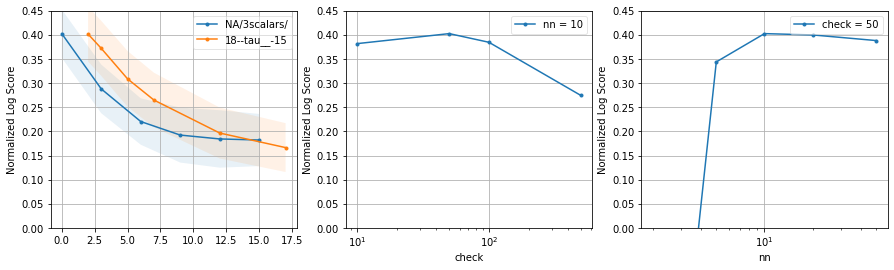

In [2]:
runs = {'NA/3scalars/' : './xforanalogs/NA24by48/global_logit/yrs500/interT15/'
        }

import matplotlib.pyplot as plt
fig2 = plt.figure()
fig2.set_size_inches(15, 4)
ax = fig2.subplots(nrows=1, ncols=3)
setnn = 10
setcheck = 50
for name, folder in runs.items():
        print(name)
        open_file = open(f'{folder}/committor.pkl', "rb")
        committor_dictionary = pickle.load(open_file)
        open_file.close()
        committor = committor_dictionary['committor']
        print(committor_dictionary.keys())
        print(committor_dictionary['RunFolds_kwargs_default'])
        delay = ut.extract_nested(committor_dictionary['RunFolds_kwargs_default'],'delay')
        chain_step = ut.extract_nested(committor_dictionary['RunFolds_kwargs_default'],'chain_step')
        import pandas as pd
        skill = committor_dictionary['skill']
        skill = []
        for check, value_check in committor_dictionary['skill'].items():
                score_nn = []
                for nn, value_nn in value_check.items():     
                        score_fold = []
                        for fold, value_fold in value_nn.items():
                                score_fold.append(pd.DataFrame([value_fold], columns = -delay*chain_step) )
                        score_nn.append(pd.concat(score_fold, keys=value_nn.keys(),names=['fold', None]))
                skill.append(pd.concat(score_nn, keys=value_check.keys(),names=['nn','fold', None]))
        skill = pd.concat(skill, keys =committor_dictionary['skill'].keys(), names=['check','nn','fold', None] )
        meanskill = skill.groupby(['check', 'nn']).mean() #.loc[(slice(None), 1), 'skill'] #.droplevel(level=(1,2)) 
        stdskill = skill.groupby(['check', 'nn']).std()
        tauarray = np.array([-tau for tau in meanskill])
        meanskilarray = np.array([meanskill[tau].max() for tau in meanskill])
        stdskillarray = np.array([stdskill[tau][meanskill[tau].idxmax()] for tau in stdskill])
        ax[0].plot(tauarray, meanskilarray,label=name, marker='.')
        ax[0].fill_between(tauarray,meanskilarray-stdskillarray,meanskilarray+stdskillarray,alpha=0.1)
        meanskill[0][(slice(None),setnn)].plot(ax = ax[1], label=f'nn = {setnn}', marker='.')
        meanskill[0].loc[pd.IndexSlice[setcheck,:]].droplevel(level=(0)).plot(ax = ax[2], label=f'check = {setcheck}', marker='.')
        for j in list(meanskill.columns):
                print(f"{meanskill[j].max():.2f}+-{stdskill[j][meanskill[j].idxmax()]:.2f}, {meanskill[j].idxmax()[0]}, {meanskill[j].idxmax()[1]}")
                
percent=5
folder = '../PLASIM/xmodels/u1yrs500/'
runs = ut.json2dict(f"{folder}/runs.json")
runs_grouped_list = ln.make_groups(runs,config_dict_flat={'tau':0})
config = ut.json2dict(f"{folder}/config.json")


for runs in [runs_grouped_list[2]]:
    dg = []
    taus = runs['tau']
    for value in runs['runs']:
        print(value['name'])
        if value['status'] != 'FAILED':
            data= pd.read_csv(f"{folder}/{value['name']}/fold_{0}/history.csv")
            #print(tau)
            df = []
            for i in range(10):
                df.append(pd.read_csv(f"{folder}/{value['name']}/fold_{i}/history.csv"))
            #print(f'{len(df) = }')
            dg.append(pd.concat(df, keys=range(10),names=['fold', None]))
    dg_frame = pd.concat(dg, keys=taus,names=['tau','fold', None])
    maxskill = -(percent/100.)*np.log(percent/100.)-(1-percent/100.)*np.log(1-percent/100.)
    dg_frame['val_CustomSkill'] = (maxskill - dg_frame['val_CustomLoss'])/maxskill
    dg_fold_mean = dg_frame.groupby(['tau','epoch']).mean()  # We need to compute fold-wise mean
    dg_idxmax = dg_fold_mean.loc[:,'val_CustomSkill'].groupby(['tau']).idxmax() # Now we compute the indices for which the val_CustomSkill is maximal because we need to apply them to standard deviation as well
    dg_foldmean_maxskill_mean = dg_frame.groupby(['tau','epoch']).mean().loc[dg_idxmax] #Now we are in a position to also compute standard deviation and mean for those columns which correspond to the optimal customskill
    dg_foldmean_maxskill_std = dg_frame.groupby(['tau','epoch']).std().loc[dg_idxmax]
    ax[0].fill_between(-dg_foldmean_maxskill_std['val_CustomSkill'].droplevel(level=1).index+2,dg_foldmean_maxskill_mean['val_CustomSkill'].values-dg_foldmean_maxskill_std['val_CustomSkill'].values,dg_foldmean_maxskill_mean['val_CustomSkill'].values+dg_foldmean_maxskill_std['val_CustomSkill'].values,alpha=0.1)
    ax[0].plot(-dg_foldmean_maxskill_std['val_CustomSkill'].droplevel(level=1).index+2,dg_foldmean_maxskill_mean['val_CustomSkill'].values, label=value['name'], marker='.')

ax[1].set_xscale('log')
ax[2].set_xscale('log')
#ax1.set_ylabel('skill')
#ax.set_ylim([0,0.5])
#ax.set_yscale("log")
for i in range(3):
        ax[i].legend(loc='best', fancybox=True, framealpha=0.5)
        ax[i].grid(True)
        ax[i].set_ylabel('Normalized Log Score')
        ax[i].set_ylim([0,0.45])

fig2.savefig('./Images/analog_taus.png',dpi=200,bbox_inches='tight')

In [63]:
meanskill[0].index.isin([ setcheck], level='check')

array([False, False, False, False, False, False,  True,  True,  True,
        True,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False])

Comparing raw analog method to VAE analog with all three fields passed through VAE

Raw Analogs
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield': 0, 'input_set': 'va', 'bulk_set': 'tr', 'RunCheckpoints_kwargs': {'allowselfanalogs': True, 'RunNeighbors_kwargs': {'num_Traj': 10000, 'T': 15, 'chain_step': 3, 'neighbors': [1, 2, 3, 5, 10, 20, 50, 100], 'delay': array([0, 1, 2, 3, 4, 5])}}}
0.40+-0.05, 50.0, 10
0.29+-0.05, 50.0, 10
0.22+-0.05, 50.0, 10
0.19+-0.06, 10.0, 20
0.18+-0.06, 10.0, 20
0.18+-0.05, 10.0, 10
North Atlantic ResNet (16)
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield': 0, 'input_set': 'va', 'bulk_set': 'tr', 'RunCheckpoints_kwargs': {'allowselfanalogs': True, 'RunNeighbors_kwargs': {'num_Traj': 10000, 'T': 15, 'chain_step': 3, 'neighbors': [1, 2, 3, 5, 10, 20, 50, 100], 'delay': array([0, 1, 2, 3, 4, 5])}}}
0.36+-0.04, 10, 10
0.23+-0.04, 10, 10
0.15+-0.03, 10, 10
0.11+-0.04, 10, 5
0.10+-0.03, 10, 5
0.09+-0.03, 10, 5
North Hemisphere (64)
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield': 

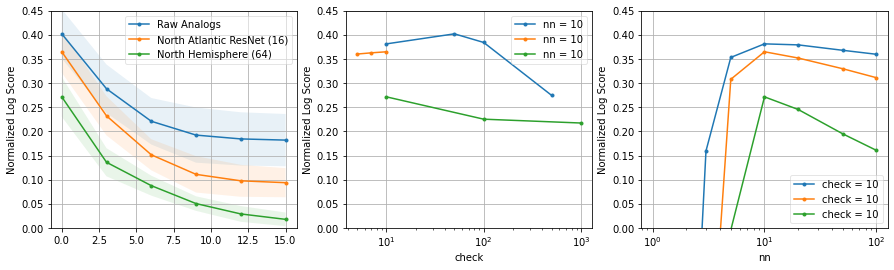

In [5]:
runs = {'Raw Analogs' : './xforanalogs/NA24by48/global_logit/yrs500/interT15/'
        #,'NA/Z8//fw20.1.20lrs4' : './xforanalogs/NA24by48/Z8/yrs500/interT15fw20.1.20lrs4/'
        #,'NA/Z8//fw20.4.20lrs4' : './xforanalogs/NA24by48/Z8/yrs500/interT15fw20.4.20lrs4/'
        #,'NA/Z8//fw20.1.20kl.5.5lrs4' : './xforanalogs/NA24by48/Z8/yrs500/interT15fw20.1.20kl.5.5lrs4/'
        #,'NA/Z8/yrs500/fw20.1.20skip2' : './xforanalogs/NA24by48/Z8/yrs500/interT15fw20.1.20skip2/'
        #,'NA/Z16//fw20.1.20lrs4' : './xforanalogs/NA24by48/Z16/yrs500/interT15fw20.1.20lrs4/'
        ,'North Atlantic ResNet (16)' : './xforanalogs/NA24by48/Z16/yrs500/interT15fw20.1.20kl.99.01skip2/'
        ,'North Hemisphere (64)' : './xforanalogs/NH24by128/Z64/yrs500/interT15fw20.1.20lrs4/'
        }

Compare_Scores(runs, setnn=10, setcheck=10, savename='./Images/analog_taus.png')

Comparing raw analog with analog VAE where only ZG has passed through autoencoder

Raw Analog
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield': 0, 'input_set': 'va', 'bulk_set': 'tr', 'RunCheckpoints_kwargs': {'allowselfanalogs': True, 'RunNeighbors_kwargs': {'num_Traj': 10000, 'T': 15, 'chain_step': 3, 'neighbors': [2, 3, 5, 10, 20, 50], 'delay': array([0, 1, 2, 3, 4, 5])}}}
0.40+-0.05, 50.0, 10
0.29+-0.05, 50.0, 10
0.22+-0.05, 50.0, 10
0.19+-0.06, 10.0, 20
0.18+-0.06, 10.0, 10
0.18+-0.05, 10.0, 10
North Atlantic ResNet (16)
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield': 0, 'input_set': 'va', 'bulk_set': 'tr', 'RunCheckpoints_kwargs': {'allowselfanalogs': True, 'RunNeighbors_kwargs': {'num_Traj': 10000, 'T': 15, 'chain_step': 3, 'neighbors': [1, 2, 3, 5, 10, 20, 50, 100], 'delay': array([0, 1, 2, 3, 4, 5])}}}
0.39+-0.05, 5.0, 10
0.28+-0.04, 5.0, 10
0.22+-0.05, 5.0, 10
0.19+-0.05, 5.0, 10
0.18+-0.06, 1.0, 5
0.18+-0.06, 1.0, 5
North Atlantic PCA (16)
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield': 

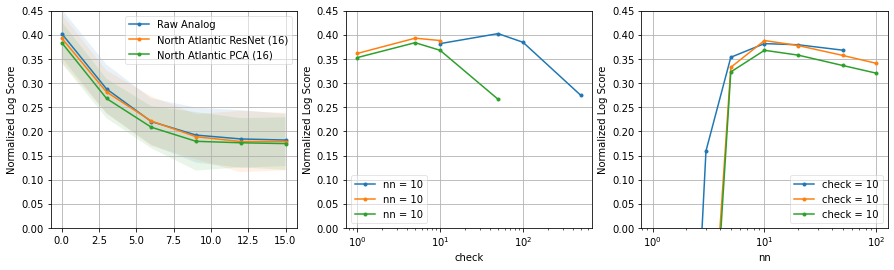

In [3]:
runs = {'Raw Analog' : './xforanalogs/NA24by48/global_logit/yrs500/interT15/'
       ,'North Atlantic ResNet (16)' : './xforanalogs/ZGonlyNA24by48/Z16/yrs500/interT15fw20.1.20ZGskip2/'
        #,'North Atlantic (64)' : './xforanalogs/ZGonlyNA24by48/Z64/yrs500/interT15fw20.1.20ZGlrs4/'
        ,'North Atlantic PCA (16)' : './xforanalogs/ZGonlyNA24by48/Z16/yrs500/interT15PCA/'
}
        
Compare_Scores(runs, setnn=10, setcheck=10, savename='./Images/analog_taus.png')

Comparing raw analog method with VAE analog 64 with 10 epochs vs 1000 epochs

Raw Analog
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield': 0, 'input_set': 'va', 'bulk_set': 'tr', 'RunCheckpoints_kwargs': {'allowselfanalogs': True, 'RunNeighbors_kwargs': {'num_Traj': 10000, 'T': 15, 'chain_step': 3, 'neighbors': [1, 2, 3, 5, 10, 20, 50, 100], 'delay': array([0, 1, 2, 3, 4, 5])}}}
0.40+-0.05, 50.0, 10
0.29+-0.05, 50.0, 10
0.22+-0.05, 50.0, 10
0.19+-0.06, 10.0, 20
0.18+-0.06, 10.0, 20
0.18+-0.05, 10.0, 10
North Atlantic (64)
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield': 0, 'input_set': 'va', 'bulk_set': 'tr', 'RunCheckpoints_kwargs': {'allowselfanalogs': True, 'RunNeighbors_kwargs': {'num_Traj': 10000, 'T': 15, 'chain_step': 3, 'neighbors': [1, 2, 3, 5, 10, 20, 50, 100], 'delay': array([0, 1, 2, 3, 4, 5])}}}
0.39+-0.04, 10.0, 20
0.28+-0.05, 10.0, 10
0.22+-0.05, 10.0, 10
0.19+-0.05, 10.0, 10
0.18+-0.05, 10.0, 10
0.18+-0.05, 5.0, 10
Norht Atlantic (64) 1000
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'

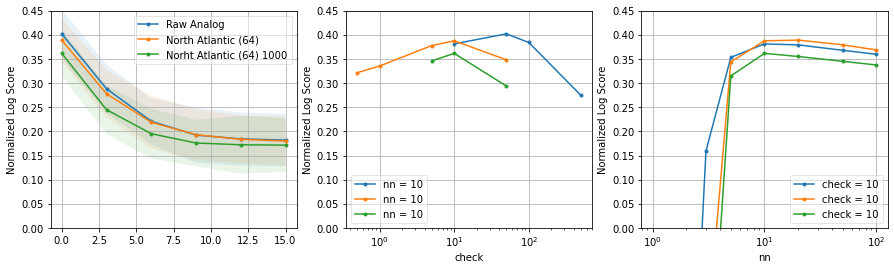

In [8]:
runs = {'Raw Analog' : './xforanalogs/NA24by48/global_logit/yrs500/interT15/'
        #,'NA/Z8//fw20.1.20lrs4' : './xforanalogs/NA24by48/Z8/yrs500/interT15fw20.1.20lrs4/'
        #,'NA/Z8//fw20.4.20lrs4' : './xforanalogs/NA24by48/Z8/yrs500/interT15fw20.4.20lrs4/'
        #,'NA/Z8//fw20.1.20kl.5.5lrs4' : './xforanalogs/NA24by48/Z8/yrs500/interT15fw20.1.20kl.5.5lrs4/'
        #,'NA/Z8/yrs500/fw20.1.20skip2' : './xforanalogs/NA24by48/Z8/yrs500/interT15fw20.1.20skip2/'
        #,'NA/Z16//fw20.1.20lrs4' : './xforanalogs/NA24by48/Z16/yrs500/interT15fw20.1.20lrs4/'
        #,'NA/Z16//fw20.1.20kl.99.01skip2' : './xforanalogs/NA24by48/Z16/yrs500/interT15fw20.1.20kl.99.01skip2/'
        #,'NH/Z64/fw20.1.20lrs4' : './xforanalogs/NH24by128/Z64/yrs500/interT15fw20.1.20lrs4/'
        #,'ZG' : './xforanalogs/ZGonlyNA24by48/Z8/yrs500/interT15ZGlrs4/'
        #,'ZGfw1.1.1' : './xforanalogs/ZGonlyNA24by48/Z8/yrs500/interT15fw1.1.1ZGlrs4/'
        #,'ZGskip2' : './xforanalogs/ZGonlyNA24by48/Z8/yrs500/interT15ZGskip2/'
        #,'ZGskip2with10epochs' : './xforanalogs/ZGonlyNA24by48/Z8/yrs500/interT15ZGskip2with10epochs/'
        #,'ZGkl.99.01skip2' : './xforanalogs/ZGonlyNA24by48/Z8/yrs500/interT15ZGkl.99.01skip2/'
        #,'North Atlantic ResNet (16)' : './xforanalogs/ZGonlyNA24by48/Z16/yrs500/interT15fw20.1.20ZGskip2/'
        #,'Z64/fw1.1.1' : './xforanalogs/ZGonlyNA24by48/Z16/yrs500/interT15fw1.1.1ZGlrs4/'
        ,'North Atlantic (64)' : './xforanalogs/ZGonlyNA24by48/Z64/yrs500/interT15fw20.1.20ZGlrs4'
        ,'Norht Atlantic (64) 1000' : './xforanalogs/ZGonlyNA24by48/Z64/yrs500/interT15fw20.1.20ZGlrs4epoch1000'
        #,'Z64/fw1.1.1epoch10' : './xforanalogs/ZGonlyNA24by48/Z64/yrs500/interT15fw1.1.1ZGepoch10lrs4/'
        #,'Z64/fw20.1.20epoch10skip2' :'./xforanalogs/ZGonlyNA24by48/Z16/yrs500/interT15fw20.1.20ZG10epochsskip2/'
        }

Compare_Scores(runs, setnn=10, setcheck=10, savename='./Images/analog_taus.png')

Comparing raw analog 500 years with raw analog 2000 years.

Raw Analog
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield': 0, 'input_set': 'va', 'bulk_set': 'tr', 'RunCheckpoints_kwargs': {'allowselfanalogs': True, 'RunNeighbors_kwargs': {'num_Traj': 10000, 'T': 15, 'chain_step': 3, 'neighbors': [1, 2, 3, 5, 10, 20, 50, 100], 'delay': array([0, 1, 2, 3, 4, 5])}}}
0.40+-0.05, 50.0, 10
0.29+-0.05, 50.0, 10
0.22+-0.05, 50.0, 10
0.19+-0.06, 10.0, 20
0.18+-0.06, 10.0, 20
0.18+-0.05, 10.0, 10
Z16/yrs2000/skip2lr5e-5
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield': 0, 'input_set': 'va', 'bulk_set': 'tr', 'RunCheckpoints_kwargs': {'allowselfanalogs': True, 'RunNeighbors_kwargs': {'num_Traj': 10000, 'T': 15, 'chain_step': 3, 'neighbors': [1, 2, 3, 5, 10, 20, 50, 100], 'delay': array([0, 1, 2, 3, 4, 5])}}}
0.39+-0.02, 10.0, 10
0.27+-0.02, 5.0, 10
0.22+-0.02, 5.0, 10
0.19+-0.02, 5.0, 10
0.17+-0.02, 5.0, 10
0.16+-0.02, 5.0, 10
Raw Analog/yrs2000
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield

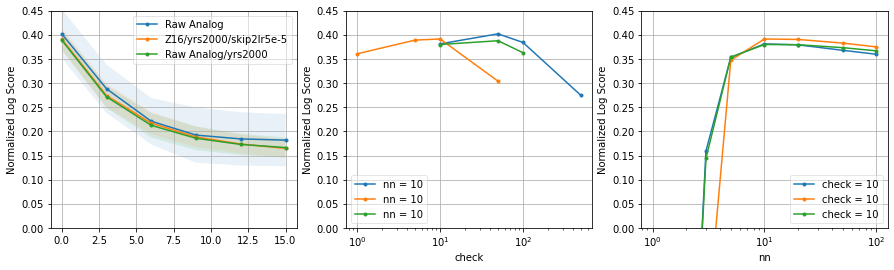

In [9]:
runs = {'Raw Analog' : './xforanalogs/NA24by48/global_logit/yrs500/interT15/'
         ,'Z16/yrs2000/skip2lr5e-5' : 'xforanalogs/ZGonlyNA24by48/Z16/yrs2000/interT15fw20.1.20ZGskip2lr5e-5/'
         ,'Raw Analog/yrs2000' :'./xforanalogs/NA24by48/global_logit/yrs2000/interT15/'
        }

Compare_Scores(runs, setnn=10, setcheck=10, savename='./Images/analog_taus.png')

Comparing with Gaussian loss

NAE ResNet (16)
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield': 0, 'input_set': 'va', 'bulk_set': 'tr', 'RunCheckpoints_kwargs': {'allowselfanalogs': True, 'RunNeighbors_kwargs': {'num_Traj': 10000, 'T': 15, 'chain_step': 3, 'neighbors': [1, 2, 3, 5, 10, 20, 50, 100], 'delay': array([0, 1, 2, 3, 4, 5])}}}
0.39+-0.05, 5.0, 10
0.28+-0.04, 5.0, 10
0.22+-0.05, 5.0, 10
0.19+-0.05, 5.0, 10
0.18+-0.06, 1.0, 5
0.18+-0.06, 1.0, 5
NAE ResNet gaussian (16)
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield': 0, 'input_set': 'va', 'bulk_set': 'tr', 'RunCheckpoints_kwargs': {'allowselfanalogs': True, 'RunNeighbors_kwargs': {'num_Traj': 10000, 'T': 15, 'chain_step': 3, 'neighbors': [1, 2, 3, 5, 10, 20, 50, 100], 'delay': array([0, 1, 2, 3, 4, 5])}}}
0.38+-0.10, 1.0, 10
0.25+-0.11, 1.0, 10
0.20+-0.10, 1.0, 10
0.20+-0.09, 1.0, 50
0.19+-0.08, 1.0, 50
0.18+-0.08, 1.0, 50
NAE Gaussian (16) KL.99.01
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'n

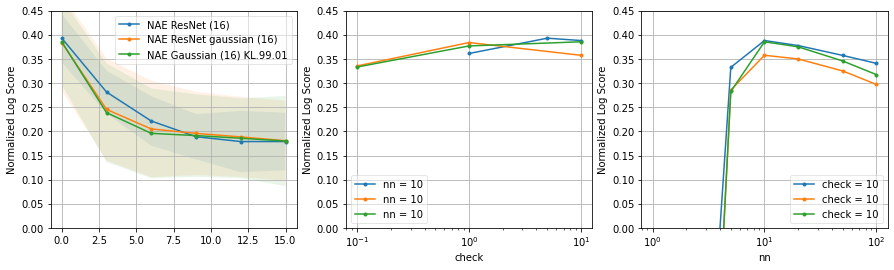

In [15]:
runs = {#'Raw Analog' : './xforanalogs/NA24by48/global_logit/yrs500/interT15/'
        #,'NA/Z8//fw20.1.20lrs4' : './xforanalogs/NA24by48/Z8/yrs500/interT15fw20.1.20lrs4/'
        #,'NA/Z8//fw20.4.20lrs4' : './xforanalogs/NA24by48/Z8/yrs500/interT15fw20.4.20lrs4/'
        #,'NA/Z8//fw20.1.20kl.5.5lrs4' : './xforanalogs/NA24by48/Z8/yrs500/interT15fw20.1.20kl.5.5lrs4/'
        #,'NA/Z8/yrs500/fw20.1.20skip2' : './xforanalogs/NA24by48/Z8/yrs500/interT15fw20.1.20skip2/'
        #,'NA/Z16//fw20.1.20lrs4' : './xforanalogs/NA24by48/Z16/yrs500/interT15fw20.1.20lrs4/'
        #,'NA/Z16//fw20.1.20kl.99.01skip2' : './xforanalogs/NA24by48/Z16/yrs500/interT15fw20.1.20kl.99.01skip2/'
        #,'NH/Z64/fw20.1.20lrs4' : './xforanalogs/NH24by128/Z64/yrs500/interT15fw20.1.20lrs4/'
        #,'ZG' : './xforanalogs/ZGonlyNA24by48/Z8/yrs500/interT15ZGlrs4/'
        #,'ZGfw1.1.1' : './xforanalogs/ZGonlyNA24by48/Z8/yrs500/interT15fw1.1.1ZGlrs4/'
        #,'ZGskip2' : './xforanalogs/ZGonlyNA24by48/Z8/yrs500/interT15ZGskip2/'
        #,'ZGskip2with10epochs' : './xforanalogs/ZGonlyNA24by48/Z8/yrs500/interT15ZGskip2with10epochs/'
        #,'ZGkl.99.01skip2' : './xforanalogs/ZGonlyNA24by48/Z8/yrs500/interT15ZGkl.99.01skip2/'
        'NAE ResNet (16)' : './xforanalogs/ZGonlyNA24by48/Z16/yrs500/interT15fw20.1.20ZGskip2/'
        #,'Z64/fw1.1.1' : './xforanalogs/ZGonlyNA24by48/Z16/yrs500/interT15fw1.1.1ZGlrs4/'
        #,'NAE (64)' : './xforanalogs/ZGonlyNA24by48/Z64/yrs500/interT15fw20.1.20ZGlrs4/'
        #,'Z64/fw1.1.1epoch10' : './xforanalogs/ZGonlyNA24by48/Z64/yrs500/interT15fw1.1.1ZGepoch10lrs4/'
        #,'Z64/fw20.1.20epoch10skip2' :'./xforanalogs/ZGonlyNA24by48/Z64/yrs500/interT15fw20.1.20ZG10epochsskip2/'
        , 'NAE ResNet gaussian (16)' : './xforanalogsL2loss/ZGonlyNA24by48/Z16/yrs500/interT15fw20.1.20skip2epochs100/'
        #, 'NAE gaussian (8)' : './xforanalogsL2loss/ZGonlyNA24by48/Z8/yrs500/interT15fw20.1.20skip2/'
        #, 'NAE Gaussian (16) KL11epoch1000' : './xforanalogsL2loss/ZGonlyNA24by48/Z16/yrs500/interT15fw20.1.20kl1.1.skip2epochs1000/'
        #, 'NAE Gaussian (16) KL11epoch10000' : 'xforanalogsL2loss/ZGonlyNA24by48/Z16/yrs500/interT15fw20.1.20kl1.1.skip2/'
        , 'NAE Gaussian (16) KL.99.01'   :'xforanalogsL2loss/ZGonlyNA24by48/Z16/yrs500/interT15fw20.1.20kl.99.01lr1e-3skip2/'
        }

Compare_Scores(runs, setnn=10, setcheck=10, savename='./Images/analog_taus.png')

Comparisons between 1 percent and 5 percent, 3 day and 1 day Markov chains

Raw Analog France 5%
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield': 0, 'input_set': 'va', 'bulk_set': 'tr', 'RunCheckpoints_kwargs': {'allowselfanalogs': True, 'RunNeighbors_kwargs': {'num_Traj': 10000, 'T': 15, 'chain_step': 3, 'neighbors': [2, 3, 5, 10, 20, 50], 'delay': array([0, 1, 2, 3, 4, 5])}}}
0.40+-0.05, 50.0, 10
0.29+-0.05, 50.0, 10
0.22+-0.05, 50.0, 10
0.19+-0.06, 10.0, 20
0.18+-0.06, 10.0, 10
0.18+-0.05, 10.0, 10
Raw Analog France daily 1%
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield': 0, 'input_set': 'va', 'bulk_set': 'tr', 'RunCheckpoints_kwargs': {'allowselfanalogs': True, 'RunNeighbors_kwargs': {'num_Traj': 10000, 'T': 15, 'chain_step': 1, 'neighbors': [1, 2, 3, 5, 10, 20, 50, 100], 'delay': array([ 0,  3,  6,  9, 12, 15])}}}
0.32+-0.05, 50.0, 5
0.23+-0.05, 50.0, 5
0.19+-0.05, 50.0, 5
0.16+-0.04, 50.0, 5
0.15+-0.04, 50.0, 5
0.15+-0.04, 10.0, 3


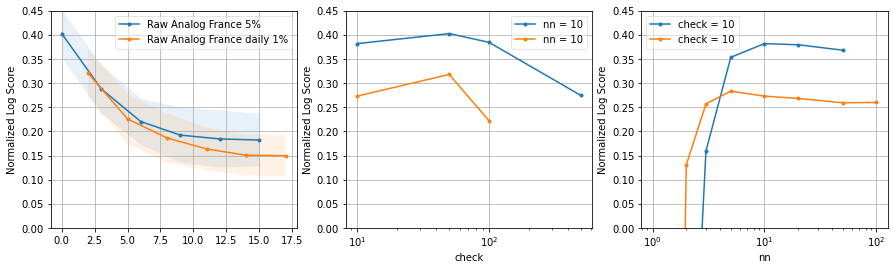

In [2]:
runs = {'Raw Analog France 5%' : './xforanalogs/NA24by48/global_logit/yrs500/interT15/'
        #,'NAE ResNet (16) France' : './xforanalogs/ZGonlyNA24by48/Z16/yrs500/interT15fw20.1.20ZGskip2/'
          #'Raw Analog Scandinavia 5%' : './xforanalogs/ZGonlyNA24by48/Scandinavia/global_logit/yrs500/interT15/'
         #, 'NAE ResNet (16) Scandinavia 5%' : './xforanalogs/ZGonlyNA24by48/Scandinavia/Z16/yrs500/interT15fw20.1.20skip2/'
         #, 'Raw Analog Scandinavia 1%' : './xforanalogs/ZGonlyNA24by48/Scandinavia/global_logit/yrs500/Per1interT15/'
         #, 'North Atlantic ResNet (16) 1%' : './xforanalogs/ZGonlyNA24by48/Scandinavia/Z16/yrs500/Per1interT15fw20.1.20skip2/'
         , 'Raw Analog France daily 1%' : ['./xforanalogs/NA24by48/global_logit/yrs500/interT15daily1percent/',2]
         #, 'Raw Analog France daily 5%' : ['./xforanalogs/NA24by48/global_logit/yrs500/interT15daily/',2]
        }

Compare_Scores(runs, setnn=10, setcheck=10, savename='./Images/analog_taus.png')

Raw Analog France 5%
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield': 0, 'input_set': 'va', 'bulk_set': 'tr', 'RunCheckpoints_kwargs': {'allowselfanalogs': True, 'RunNeighbors_kwargs': {'num_Traj': 10000, 'T': 15, 'chain_step': 3, 'neighbors': [2, 3, 5, 10, 20, 50], 'delay': array([0, 1, 2, 3, 4, 5])}}}
0.40+-0.05, 50.0, 10
0.29+-0.05, 50.0, 10
0.22+-0.05, 50.0, 10
0.19+-0.06, 10.0, 20
0.18+-0.06, 10.0, 10
0.18+-0.05, 10.0, 10
Raw Analog France daily 5%
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield': 0, 'input_set': 'va', 'bulk_set': 'tr', 'RunCheckpoints_kwargs': {'allowselfanalogs': True, 'RunNeighbors_kwargs': {'num_Traj': 100000, 'T': 15, 'chain_step': 1, 'neighbors': [1, 2, 3, 5, 10, 20, 50, 100], 'delay': array([ 0,  3,  6,  9, 12, 15])}}}
0.33+-0.05, 50.0, 5
0.24+-0.05, 50.0, 5
0.18+-0.05, 50.0, 5
0.17+-0.07, 10.0, 3
0.17+-0.06, 10.0, 3
0.17+-0.06, 10.0, 3


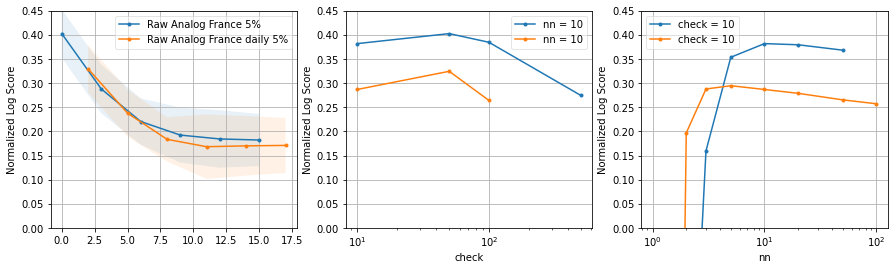

In [3]:
runs = {'Raw Analog France 5%' : './xforanalogs/NA24by48/global_logit/yrs500/interT15/'
        #,'NAE ResNet (16) France' : './xforanalogs/ZGonlyNA24by48/Z16/yrs500/interT15fw20.1.20ZGskip2/'
          #'Raw Analog Scandinavia 5%' : './xforanalogs/ZGonlyNA24by48/Scandinavia/global_logit/yrs500/interT15/'
         #, 'NAE ResNet (16) Scandinavia 5%' : './xforanalogs/ZGonlyNA24by48/Scandinavia/Z16/yrs500/interT15fw20.1.20skip2/'
         #, 'Raw Analog Scandinavia 1%' : './xforanalogs/ZGonlyNA24by48/Scandinavia/global_logit/yrs500/Per1interT15/'
         #, 'North Atlantic ResNet (16) 1%' : './xforanalogs/ZGonlyNA24by48/Scandinavia/Z16/yrs500/Per1interT15fw20.1.20skip2/'
         #, 'Raw Analog France daily 1%' : ['./xforanalogs/NA24by48/global_logit/yrs500/interT15daily1percent/',2]
         , 'Raw Analog France daily 5%' : ['./xforanalogs/NA24by48/global_logit/yrs500/interT15daily/',2]
        }

Compare_Scores(runs, setnn=10, setcheck=10, savename='./Images/analog_taus.png')

Comparing France and Scandinavia

Raw Analog France 5%
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield': 0, 'input_set': 'va', 'bulk_set': 'tr', 'RunCheckpoints_kwargs': {'allowselfanalogs': True, 'RunNeighbors_kwargs': {'num_Traj': 10000, 'T': 15, 'chain_step': 3, 'neighbors': [2, 3, 5, 10, 20, 50], 'delay': array([0, 1, 2, 3, 4, 5])}}}
meanskill[0].items() = <zip object at 0x7f45d5863c00>
0.40+-0.05, 50.0, 10
0.29+-0.05, 50.0, 10
0.22+-0.05, 50.0, 10
0.19+-0.06, 10.0, 20
0.18+-0.06, 10.0, 10
0.18+-0.05, 10.0, 10
NAE ResNet (16) France
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield': 0, 'input_set': 'va', 'bulk_set': 'tr', 'RunCheckpoints_kwargs': {'allowselfanalogs': True, 'RunNeighbors_kwargs': {'num_Traj': 10000, 'T': 15, 'chain_step': 3, 'neighbors': [1, 2, 3, 5, 10, 20, 50, 100], 'delay': array([0, 1, 2, 3, 4, 5])}}}
meanskill[0].items() = <zip object at 0x7f45d5872940>
0.39+-0.05, 5.0, 10
0.28+-0.04, 5.0, 10
0.22+-0.05, 5.0, 10
0.19+-0.05, 5.0, 10
0.18+-0.06, 1.0, 5
0

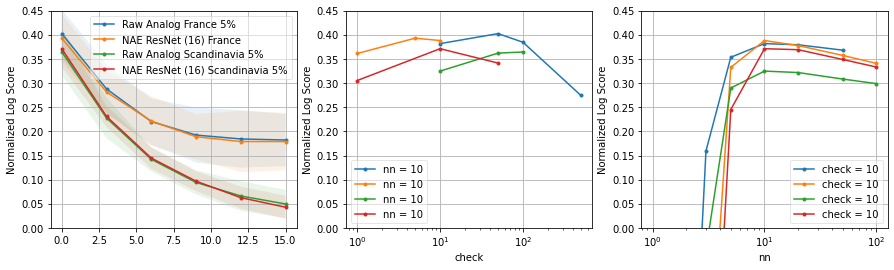

In [17]:
runs = {'Raw Analog France 5%' : './xforanalogs/NA24by48/global_logit/yrs500/interT15/'
        ,'NAE ResNet (16) France' : './xforanalogs/ZGonlyNA24by48/Z16/yrs500/interT15fw20.1.20ZGskip2/'
        ,  'Raw Analog Scandinavia 5%' : './xforanalogs/ZGonlyNA24by48/Scandinavia/global_logit/yrs500/interT15/'
         , 'NAE ResNet (16) Scandinavia 5%' : './xforanalogs/ZGonlyNA24by48/Scandinavia/Z16/yrs500/interT15fw20.1.20skip2/'
        }

Compare_Scores(runs, setnn=10, setcheck=10, savename='./Images/analog_taus.png')

NAE for France
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield': 0, 'input_set': 'va', 'bulk_set': 'tr', 'RunCheckpoints_kwargs': {'allowselfanalogs': True, 'RunNeighbors_kwargs': {'num_Traj': 10000, 'T': 15, 'chain_step': 3, 'neighbors': [2, 3, 5, 10, 20, 50], 'delay': array([0, 1, 2, 3, 4, 5])}}}
0.40+-0.05, 50.0, 10
0.29+-0.05, 50.0, 10
0.22+-0.05, 50.0, 10
0.19+-0.06, 10.0, 20
0.18+-0.06, 10.0, 10
0.18+-0.05, 10.0, 10
NH for France
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield': 0, 'input_set': 'va', 'bulk_set': 'tr', 'RunCheckpoints_kwargs': {'start_calendar_day': None, 'start_day_set': 'va', 'allowselfanalogs': True, 'RunNeighbors_kwargs': {'num_Traj': 10000, 'T': 15, 'chain_step': 3, 'neighbors': [2, 3, 5, 10, 20, 50], 'delay': array([0, 1, 2, 3, 4, 5]), 'num_steps': None}}}
0.38+-0.05, 50.0, 20
0.27+-0.04, 50.0, 20
0.22+-0.05, 50.0, 10
0.19+-0.05, 50.0, 10
0.18+-0.04, 50.0, 10
0.18+-0.05, 10.0, 50


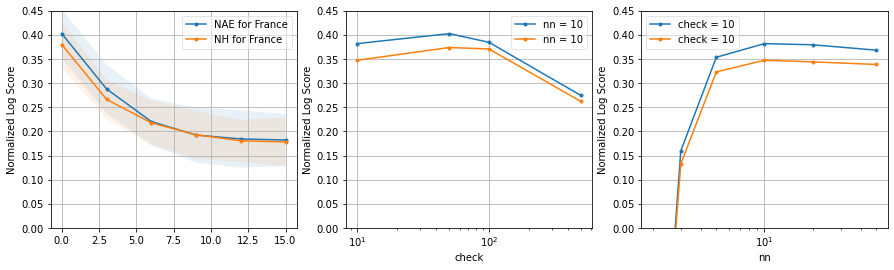

In [7]:
runs = {'NAE for France' : './xforanalogs/NA24by48/global_logit/yrs500/interT15/'
        ,'NH for France' : './xforanalogs/NH24by128/global_logit/yrs500/interT15/'
        
        #,'North Hemisphere shallow (16)' : './xforanalogs/NH24by128/Z16/yrs500/interT15L2Conv2dense1linear/'
}
        
Compare_Scores(runs, setnn=10, setcheck=10, savename='./Images/analog_taus.png')

France 500 yrs
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield': 0, 'input_set': 'va', 'bulk_set': 'tr', 'RunCheckpoints_kwargs': {'allowselfanalogs': True, 'RunNeighbors_kwargs': {'num_Traj': 10000, 'T': 15, 'chain_step': 3, 'neighbors': [2, 3, 5, 10, 20, 50], 'delay': array([0, 1, 2, 3, 4, 5])}}}
0.40+-0.05, 50.0, 10
0.29+-0.05, 50.0, 10
0.22+-0.05, 50.0, 10
0.19+-0.06, 10.0, 20
0.18+-0.06, 10.0, 10
0.18+-0.05, 10.0, 10
France 100 yrs
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield': 0, 'input_set': 'va', 'bulk_set': 'tr', 'RunCheckpoints_kwargs': {'windwsize': 30, 'start_calendar_day': None, 'start_day_set': 'va', 'allowselfanalogs': True, 'removeoutsidemovingwindow': False, 'RunNeighbors_kwargs': {'num_Traj': 10000, 'T': 15, 'chain_step': 3, 'neighbors': [2, 3, 5, 10, 20, 50], 'delay': array([0, 1, 2, 3, 4, 5]), 'num_steps': None}}}
0.39+-0.09, 50.0, 20
0.26+-0.09, 50.0, 20
0.22+-0.10, 50.0, 10
0.20+-0.10, 10.0, 10
0.19+-0.08, 10.0, 50
0.

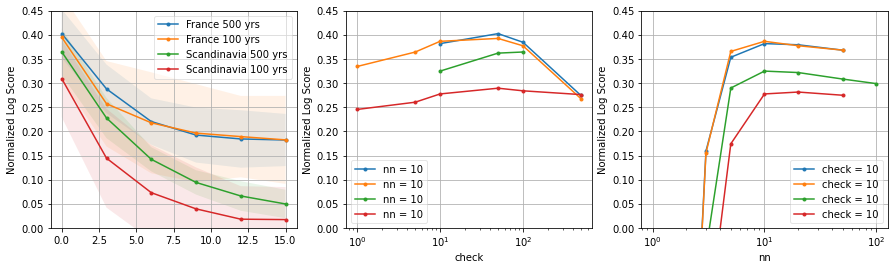

In [10]:
runs = {'France 500 yrs' : './xforanalogs/NA24by48/global_logit/yrs500/interT15/'
        ,'France 100 yrs' : './xforanalogs/NA24by48/global_logit/yrs100/interT15/'
        ,'Scandinavia 500 yrs' : './xforanalogs/ZGonlyNA24by48/Scandinavia/global_logit/yrs500/interT15'
        ,'Scandinavia 100 yrs' : './xforanalogs/ZGonlyNA24by48/Scandinavia/global_logit/yrs100/interT15'
}
        
Compare_Scores(runs, setnn=10, setcheck=10, savename='./Images/analog_NAEvsNH.png')

Raw Analog 500 yrs
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield': 0, 'input_set': 'va', 'bulk_set': 'tr', 'RunCheckpoints_kwargs': {'allowselfanalogs': True, 'RunNeighbors_kwargs': {'num_Traj': 10000, 'T': 15, 'chain_step': 3, 'neighbors': [1, 2, 3, 5, 10, 20, 50, 100], 'delay': array([0, 1, 2, 3, 4, 5])}}}
0.36+-0.05, 100.0, 20
0.23+-0.04, 100.0, 10
0.14+-0.02, 100.0, 10
0.09+-0.03, 100.0, 10
0.07+-0.03, 50.0, 10
0.05+-0.03, 50.0, 10
Raw Analog 100 yrs
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield': 0, 'input_set': 'va', 'bulk_set': 'tr', 'RunCheckpoints_kwargs': {'windwsize': 30, 'start_calendar_day': None, 'start_day_set': 'va', 'allowselfanalogs': True, 'removeoutsidemovingwindow': False, 'RunNeighbors_kwargs': {'num_Traj': 10000, 'T': 15, 'chain_step': 3, 'neighbors': [2, 3, 5, 10, 20, 50], 'delay': array([0, 1, 2, 3, 4, 5]), 'num_steps': None}}}
0.31+-0.08, 50.0, 20
0.14+-0.10, 50.0, 20
0.07+-0.10, 50.0, 20
0.04+-0.09, 50.0, 20
0.0

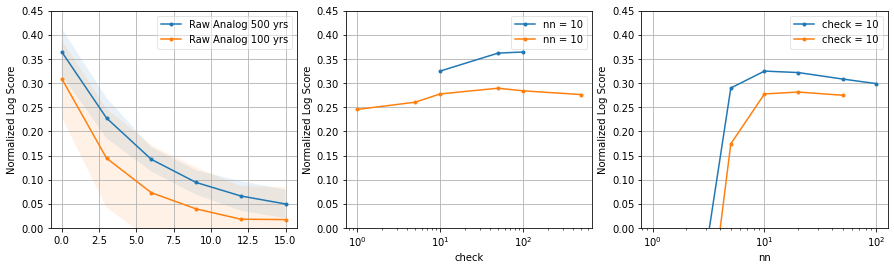

In [8]:
runs = {'Raw Analog 500 yrs' : './xforanalogs/ZGonlyNA24by48/Scandinavia/global_logit/yrs500/interT15'
        ,'Raw Analog 100 yrs' : './xforanalogs/ZGonlyNA24by48/Scandinavia/global_logit/yrs100/interT15'
}
        
Compare_Scores(runs, setnn=10, setcheck=10, savename='./Images/Scandinavia_100vs500.png')

Scandinavia CNN vs analogs

NA/3scalars/
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield': 0, 'input_set': 'va', 'bulk_set': 'tr', 'RunCheckpoints_kwargs': {'allowselfanalogs': True, 'RunNeighbors_kwargs': {'num_Traj': 10000, 'T': 15, 'chain_step': 3, 'neighbors': [1, 2, 3, 5, 10, 20, 50, 100], 'delay': array([0, 1, 2, 3, 4, 5])}}}
0.36+-0.05, 100.0, 20
0.23+-0.04, 100.0, 10
0.14+-0.02, 100.0, 10
0.09+-0.03, 100.0, 10
0.07+-0.03, 50.0, 10
0.05+-0.03, 50.0, 10
0
1--tau__-1
2--tau__-3
3--tau__-5
4--tau__-10
5--tau__-15


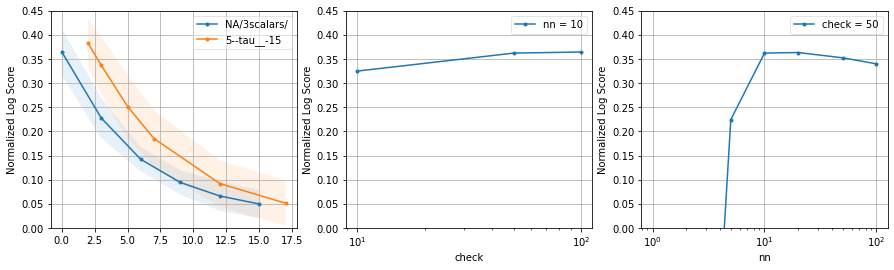

In [11]:
runs = {'NA/3scalars/' : './xforanalogs/ZGonlyNA24by48/Scandinavia/global_logit/yrs500/interT15/'
        }

import matplotlib.pyplot as plt
fig2 = plt.figure()
fig2.set_size_inches(15, 4)
ax = fig2.subplots(nrows=1, ncols=3)
setnn = 10
setcheck = 50
for name, folder in runs.items():
        print(name)
        open_file = open(f'{folder}/committor.pkl', "rb")
        committor_dictionary = pickle.load(open_file)
        open_file.close()
        committor = committor_dictionary['committor']
        print(committor_dictionary.keys())
        print(committor_dictionary['RunFolds_kwargs_default'])
        delay = ut.extract_nested(committor_dictionary['RunFolds_kwargs_default'],'delay')
        chain_step = ut.extract_nested(committor_dictionary['RunFolds_kwargs_default'],'chain_step')
        import pandas as pd
        skill = committor_dictionary['skill']
        skill = []
        for check, value_check in committor_dictionary['skill'].items():
                score_nn = []
                for nn, value_nn in value_check.items():     
                        score_fold = []
                        for fold, value_fold in value_nn.items():
                                score_fold.append(pd.DataFrame([value_fold], columns = -delay*chain_step) )
                        score_nn.append(pd.concat(score_fold, keys=value_nn.keys(),names=['fold', None]))
                skill.append(pd.concat(score_nn, keys=value_check.keys(),names=['nn','fold', None]))
        skill = pd.concat(skill, keys =committor_dictionary['skill'].keys(), names=['check','nn','fold', None] )
        meanskill = skill.groupby(['check', 'nn']).mean() #.loc[(slice(None), 1), 'skill'] #.droplevel(level=(1,2)) 
        stdskill = skill.groupby(['check', 'nn']).std()
        tauarray = np.array([-tau for tau in meanskill])
        meanskilarray = np.array([meanskill[tau].max() for tau in meanskill])
        stdskillarray = np.array([stdskill[tau][meanskill[tau].idxmax()] for tau in stdskill])
        ax[0].plot(tauarray, meanskilarray,label=name, marker='.')
        ax[0].fill_between(tauarray,meanskilarray-stdskillarray,meanskilarray+stdskillarray,alpha=0.1)
        meanskill[0][(slice(None),setnn)].plot(ax = ax[1], label=f'nn = {setnn}', marker='.')
        meanskill[0].loc[pd.IndexSlice[setcheck,:]].droplevel(level=(0)).plot(ax = ax[2], label=f'check = {setcheck}', marker='.')
        for j in list(meanskill.columns):
                print(f"{meanskill[j].max():.2f}+-{stdskill[j][meanskill[j].idxmax()]:.2f}, {meanskill[j].idxmax()[0]}, {meanskill[j].idxmax()[1]}")
                
percent=5
folder = '../PLASIM/xmodels/Scandinavia/u1yrs500'
runs = ut.json2dict(f"{folder}/runs.json")
runs_grouped_list = ln.make_groups(runs,config_dict_flat={'tau':0})
config = ut.json2dict(f"{folder}/config.json")


for runs in [runs_grouped_list[0]]:
    dg = []
    taus = runs['tau']
    for value in runs['runs']:
        print(value['name'])
        if value['status'] != 'FAILED':
            data= pd.read_csv(f"{folder}/{value['name']}/fold_{0}/history.csv")
            #print(tau)
            df = []
            for i in range(10):
                df.append(pd.read_csv(f"{folder}/{value['name']}/fold_{i}/history.csv"))
            #print(f'{len(df) = }')
            dg.append(pd.concat(df, keys=range(10),names=['fold', None]))
    dg_frame = pd.concat(dg, keys=taus,names=['tau','fold', None])
    maxskill = -(percent/100.)*np.log(percent/100.)-(1-percent/100.)*np.log(1-percent/100.)
    dg_frame['val_CustomSkill'] = (maxskill - dg_frame['val_CustomLoss'])/maxskill
    dg_fold_mean = dg_frame.groupby(['tau','epoch']).mean()  # We need to compute fold-wise mean
    dg_idxmax = dg_fold_mean.loc[:,'val_CustomSkill'].groupby(['tau']).idxmax() # Now we compute the indices for which the val_CustomSkill is maximal because we need to apply them to standard deviation as well
    dg_foldmean_maxskill_mean = dg_frame.groupby(['tau','epoch']).mean().loc[dg_idxmax] #Now we are in a position to also compute standard deviation and mean for those columns which correspond to the optimal customskill
    dg_foldmean_maxskill_std = dg_frame.groupby(['tau','epoch']).std().loc[dg_idxmax]
    ax[0].fill_between(-dg_foldmean_maxskill_std['val_CustomSkill'].droplevel(level=1).index+2,dg_foldmean_maxskill_mean['val_CustomSkill'].values-dg_foldmean_maxskill_std['val_CustomSkill'].values,dg_foldmean_maxskill_mean['val_CustomSkill'].values+dg_foldmean_maxskill_std['val_CustomSkill'].values,alpha=0.1)
    ax[0].plot(-dg_foldmean_maxskill_std['val_CustomSkill'].droplevel(level=1).index+2,dg_foldmean_maxskill_mean['val_CustomSkill'].values, label=value['name'], marker='.')

ax[1].set_xscale('log')
ax[2].set_xscale('log')
#ax1.set_ylabel('skill')
#ax.set_ylim([0,0.5])
#ax.set_yscale("log")
for i in range(3):
        ax[i].legend(loc='best', fancybox=True, framealpha=0.5)
        ax[i].grid(True)
        ax[i].set_ylabel('Normalized Log Score')
        ax[i].set_ylim([0,0.45])

fig2.savefig('./Images/Scandinavia_committor.png',dpi=200,bbox_inches='tight')